In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import networkx as nx

In [2]:
from nbhd import data

In [3]:
db = data.Base()

Initializing database connection...
Database connected!


In [4]:
def get_properties_in_buildings(db, polygon):
    
    # query db for nearest building for each property in polygon
    df = db.knn('properties', 'buildings', polygon)
    
    # if a property is in a building, then the distance
    # between it and its nearest building is 0
    return df.loc[df.dist==0]

In [5]:
def get_residential_streets(db, polygon, residential_street_threshold, short_threshold):
    '''
    Return dataframe of streets marked `short_or_residential`.
    '''
 
    # first we need to know how many residential properties are on each street
    properties_on_streets_df = get_properties_on_streets(db, polygon)
    properties_on_streets_df['residential'] = mark_residential_properties(
        properties_on_streets_df, db, polygon)
    residential_properties_df = properties_on_streets_df.loc[properties_on_streets_df.residential]

    # the `roads_id` is repeated every time a property has it as nearest road
    property_counts_dict = dict(residential_properties_df.roads_id.value_counts())

    # we can now ignore the individual properties and focus on the streets
    streets = residential_properties_df[
        ~residential_properties_df.roads_id.duplicated()][
        ['roads_id','startNode','endNode','roads_geometry']]
    streets['number_of_properties'] = streets.roads_id.apply(
        lambda roads_id: property_counts_dict.get(roads_id, 0))
    streets['length'] = gpd.GeoSeries.from_wkb(streets.roads_geometry).length
    streets['length_per_property'] = streets.length / streets.number_of_properties
    streets['residential'] = (streets.length_per_property < residential_street_threshold)
    streets['short'] = (streets.length < short_threshold)
    streets['short_or_residential'] = (streets.residential | streets.short)
    
    return streets

In [6]:
def get_properties_on_streets(db, polygon):
    
    return db.knn('properties', 'roads', polygon,
               t2_columns=['"startNode"', '"endNode"'])
    
    

In [7]:
def mark_residential_properties(properties, db, polygon, consider_footprint=False, consider_nearby_labels=False):
    df = properties.copy()
    # we say a property is residential if it is in a building
    properties_in_buildings = get_properties_in_buildings(db, polygon)
    
    if consider_footprint:
    # and if that building is not institutional
    # which currently we decide on the basis of footprint size.
        pass
    
    df['residential'] = df.properties_id.apply(
        lambda properties_id: properties_id in properties_in_buildings.properties_id.values)
    return df.residential

In [8]:
def mark_residential_buildings(properties_in_buildings_df):
    
    df = properties_in_buildings_df.copy()
    pass


In [9]:
def snap_together_nearby_nodes(streets_df):
    
    # logic to snap together nearby nodes
    
    return streets_df
    

In [10]:
def label_connected_communities(df):
    
    streets_df = df.copy()
    street_graph = nx.from_pandas_edgelist(streets_df, 'startNode', 'endNode', True)
    subgraphs = [street_graph.subgraph(component) for component in nx.connected_components(street_graph)]

    communities = { 
        str(i+1).zfill(3):
             list(nx.get_edge_attributes(graph, 'roads_id').values()) 
             for i, graph in enumerate(subgraphs)}

    communities_key = {
        value : key
        for key, value_list in communities.items() for value in value_list
    }

    return streets_df.roads_id.apply(lambda street_id: communities_key.get(street_id, None))

In [11]:
def get_communities(db,
                    polygon, 
                    residential_street_threshold=30,
                    short_threshold=10,
                    snap_nodes_threshold=0,
                    as_geodf=False):
    '''
    Get networks of connected residential street communities.
    '''
    
    streets = get_residential_streets(
        db, polygon, residential_street_threshold, short_threshold)
   
    if snap_nodes_threshold > 0:
        snap_together_nearby_nodes(streets)

    streets['community'] = label_connected_communities(
        streets.loc[streets.short_or_residential])

    if as_geodf:
        return gpd.GeoDataFrame(
            streets, geometry=gpd.GeoSeries.from_wkb(streets.roads_geometry))
    else: 
        return streets

In [12]:
here = db.query("SELECT geometry FROM names WHERE name1='L13 7EQ'",True)

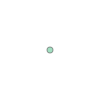

In [13]:
here.geometry[0]

In [14]:
p = db.intersects('pixels',here.geometry[0])

In [15]:
pixel = p.geometry[0]

In [16]:
settings = {'footprint_threshold':1000,
            'res_length_threshold':30,
            'short_threshold':0,
            'node_distance':5,
           'min_community_size':10}

In [17]:
streets = get_communities(db, pixel, as_geodf=True)

<AxesSubplot:>

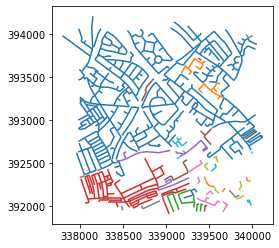

In [18]:
streets.plot('community')